In [2]:
import sys
import os
sys.path.append('../src')

from config import *
from gaia_queries import *
from data_processing import *
from plotting import *
from stellar_calculations import *
from utils import *
from catalog_integration import CatalogProcessor, add_rhk_to_dataframe
from filtering import filter_stellar_data
from gaia_tess_overlap import match_gaia_tess, save_overlapping_stars

In [2]:
if 1: # read from HWO_target_list_164.txt (with more information) 

    file_path = "../data/HWO_target_list_164.txt"

    # Read the file into a DataFrame
    df_HWO = pd.read_csv(file_path, sep="\t", header=36, usecols=lambda column: column != 'loc_rowid')

    # Read the column headers from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
        column_headers = [line.split(':')[1].strip() for line in lines[5:35]]

    # Add ' (HWO)' to each column header
    column_headers = [f"{header} (HWO)" for header in column_headers]

    # Assign the new column headers to the DataFrame
    df_HWO.columns = column_headers

    filename = '../data/HWO_target_list_164_update.xlsx'
    df_HWO.to_excel(filename, index=False)

    # Display the first few rows of the DataFrame
    display(df_HWO.head())
    


,HIP ID (HWO),HIP Component ID (HWO),HD ID (HWO),HR ID (HWO),GJ ID (HWO),Constellation ID (HWO),Host Name (HWO),Distance [pc] (HWO),RA [deg] (HWO),Dec [deg] (HWO),...,Stellar Metallicity [dex] (HWO),Stellar Surface Gravity [log10(cm/s**2)] (HWO),Stellar Ca II Chromospheric Activity Index [log R HK] (HWO),Earth Equivalent Insolation Distance [au] (HWO),Earth Equivalent Insolation Distance [mas] (HWO),Earth Equivalent Planet-Star Ratio (HWO),Earth Equivalent R (Cousins) Magnitude (HWO),Orbital Period at EEID [days] (HWO),Earth Equivalent Radial Velocity Amplitude [cm/s] (HWO),Earth Equivalent Astrometric Amplitude [uas] (HWO)
0,HIP 42438,NaN,HD 72905,HR 3391,GJ 311,3 UMa,3 Ursae Majoris A,14.4388,129.798769,65.020906,...,-0.07,4.53,-4.375,0.987,68.32,1.190000e-10,30.07,345.2,8.74,0.191
1,HIP 44897,NaN,HD 78366,HR 3625,GJ 334.2,NaN,HD 78366,18.9498,137.212793,33.882218,...,0.04,4.50,-4.608,1.126,59.41,9.130000e-11,30.69,419.8,8.16,0.165
2,HIP 45038,A,HD 78154 A,HR 3616 A,GJ 335A,13 UMa A,13 Ursae Majoris A,20.5169,137.598111,67.134017,...,-0.02,4.07,-4.901,2.018,98.34,2.840000e-11,30.89,951.6,5.76,0.244
3,HIP 48113,NaN,HD 84737,HR 3881,GJ 368,NaN,HD 84737,18.8226,147.147381,46.021007,...,0.10,4.12,-5.085,1.672,88.83,4.140000e-11,30.66,761.6,6.71,0.248
4,HIP 51459,A,HD 90839,HR 4112 A,GJ 395,36 UMa A,36 Ursae Majoris A,12.9452,157.656580,55.980539,...,-0.12,4.43,-4.775,1.267,97.87,7.210000e-11,29.87,479.5,7.36,0.249


In [3]:
merged_df = pd.read_excel('../results/Gaia_homogeneous_target_selection_M_earth_4_2025.08.13.xlsx', dtype={'source_id': str, 'source_id_dr2': str, 'source_id_dr3': str, 'HIP Number': str})

# Add ' (Jinglin)' to each column name
# merged_df.columns = [f"{col} (jzhao)" for col in merged_df.columns]

merged_df.head()
# merged_df.shape

,source_id,source_id_dr2,source_id_dr3,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,...,Gaia Spectral type,HD Number,GJ Number,HIP Number,Object Type,Stellar Parameter Source,SIMBAD Spectral Type,Readable Spectral Type (experimental),Distance [pc],V_mag_group
0,Gaia DR3 6412595290592307840,6412595290592307840,6412595290592307840,330.872408,-56.797255,4.673484,4.322904,4.907977,3.610557,1.297420,...,K,HD 209100,GJ 845,108870,PM*,GAIA,K5V,K5V,3.638439,Brightest
1,Gaia DR3 4109034455276324608,4109034455276324608,4109034455276324608,259.053294,-26.551146,6.293555,5.889863,6.530970,5.116134,1.414836,...,K,HD 156026,GJ 664.0,84478,RS*,GAIA,K5V,K5V,5.953739,Bright
2,Gaia DR3 6232511606838403968,6232511606838403968,6232511606838403968,224.371594,-21.423140,5.725483,5.364037,5.960628,4.637024,1.323604,...,K,HD 131977,GJ 570,73184,BY*,NaN,K4V,K4V,5.886360,Bright
3,Gaia DR3 6697578465310949376,6697578465310949376,6697578465310949376,302.802269,-36.108217,5.276641,5.033037,5.506255,4.404858,1.101397,...,NaN,HD 191408,GJ 783,99461,PM*,GAIA,K2.5V,K2.5V,6.012246,Bright
4,Gaia DR3 4109030160308317312,4109030160308317312,4109030160308317312,258.835117,-26.607898,5.053979,4.828591,5.282556,4.222806,1.059750,...,G,HD 155885,GJ 663,NaN,PM*,GAIA,K1V,K1V,5.947769,Bright


In [4]:

# ---------------------------------------------------------------- #
#  Add a column in merged_df to label matches with HWO
# ---------------------------------------------------------------- #
# Check for matches on HD, GJ, or HIP numbers

# Match on HD Number
hd_match = merged_df['HD Number'].isin(df_HWO['HD ID (HWO)'])

# Match on GJ Number, if available
if 'GJ Number' in merged_df.columns and 'GJ ID (HWO)' in df_HWO.columns:
    gj_match = merged_df['GJ Number'].astype(str).isin(df_HWO['GJ ID (HWO)'].astype(str))
else:
    gj_match = False

# Match on HIP Number, if available
if 'HIP Number' in merged_df.columns and 'HIP ID (HWO)' in df_HWO.columns:
    hip_match = merged_df['HIP Number'].astype(str).isin(df_HWO['HIP ID (HWO)'].astype(str))
else:
    hip_match = False

# Combine all matches
if isinstance(gj_match, bool) and isinstance(hip_match, bool):
    match_mask = hd_match
else:
    match_mask = hd_match | gj_match | hip_match

# Add the column to merged_df
merged_df['HWO_match'] = 0
merged_df.loc[match_mask, 'HWO_match'] = 1

# Optionally, save the updated merged_df to a file
filename = '../results/merged_df_with_HWO_match_M_earth_4_jzhao_2025.08.13.xlsx'
merged_df.to_excel(filename, index=False)
adjust_column_widths(filename)

# If you want to extract the overlapping part (those in merged_df that matched to HWO):
merged_df_overlap = merged_df[merged_df['HWO_match'] == 1].copy()
filename_overlap = '../results/merged_df_overlap_with_HWO_M_earth_4_jzhao_2025.08.13.xlsx'
merged_df_overlap.to_excel(filename_overlap, index=False)
adjust_column_widths(filename_overlap)

# analyze_stellar_data(merged_df_overlap)


In [7]:
def plot_scatter_with_options(df, col_x, col_y, min_value=None, max_value=None, label=False):
    # Create a scatter plot with color mapping
    plt.figure(figsize=(8, 6), dpi=150)
    scatter = plt.scatter(
        df[col_x], 
        df[col_y], 
        c=df['T_eff [K]'], 
        cmap='autumn', 
        edgecolor='k', 
        alpha=0.7
    )

    # Add titles and labels
    # plt.title('Selection Crossmatch', fontsize=14)
    plt.xlabel(f'{col_x}', fontsize=12)
    plt.ylabel(f'{col_y}', fontsize=12)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('T_eff [K]', fontsize=12)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot the x = y line
    if min_value is None:
        min_value = min(min(df[col_x]), min(df[col_y]))
    if max_value is None:
        max_value = max(max(df[col_x]), max(df[col_y]))
    plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--')
    plt.xlim(min_value, max_value)
    plt.ylim(min_value, max_value)

    if label:
        # Add labels to each point
        x_range = max_value - min_value
        x_offset = x_range * 0.01
        for i, name in enumerate(df['HD ID (HWO)']):
            if (df[col_x][i] > min_value) and (df[col_x][i] < max_value) and (df[col_y][i] > min_value) and (df[col_y][i] < max_value):
                plt.text(df[col_x][i] - x_offset, df[col_y][i], name, fontsize=5, ha='right')    

    plt.tight_layout()
    plt.savefig('../figures/HWO/crossmatch_' + col_y.strip().replace(" ", "_").replace("[", "").replace("]", "").replace("/", "") + '.png')
    # Show the plot
    plt.show()


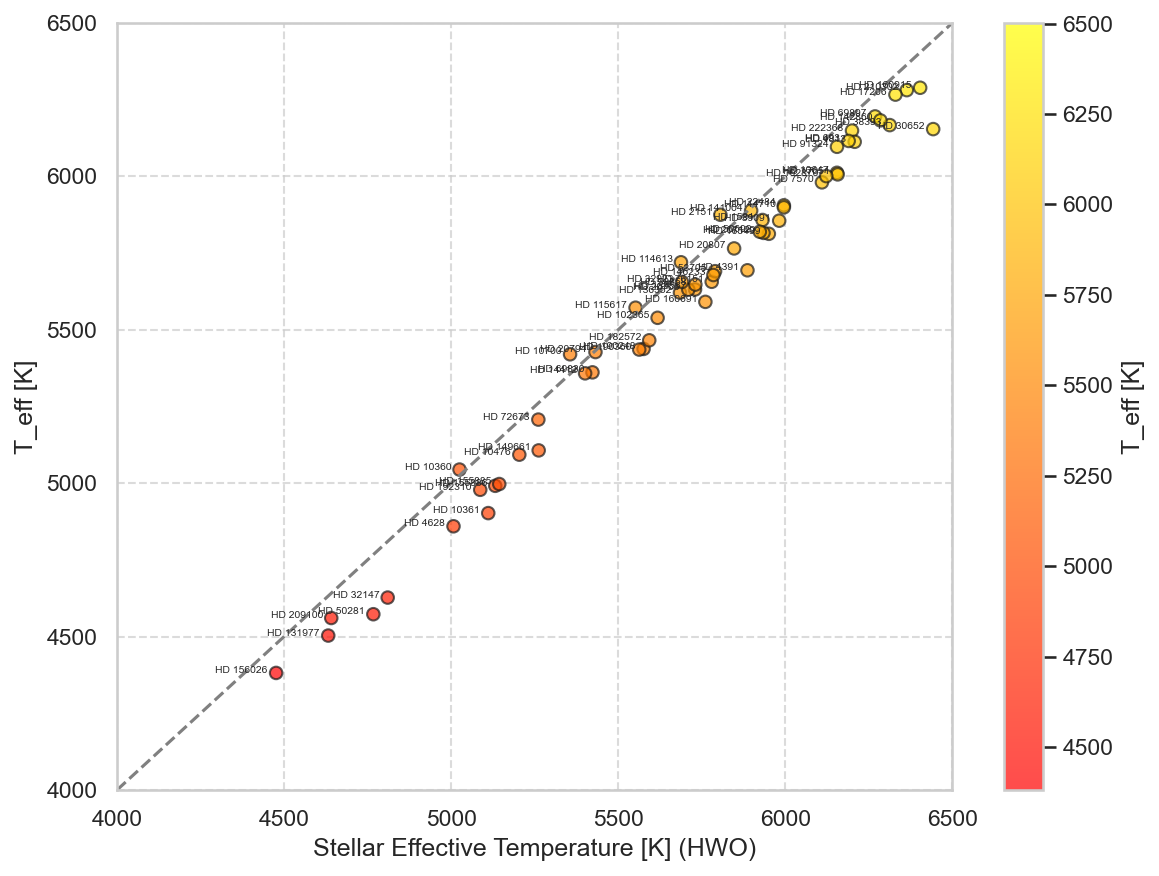

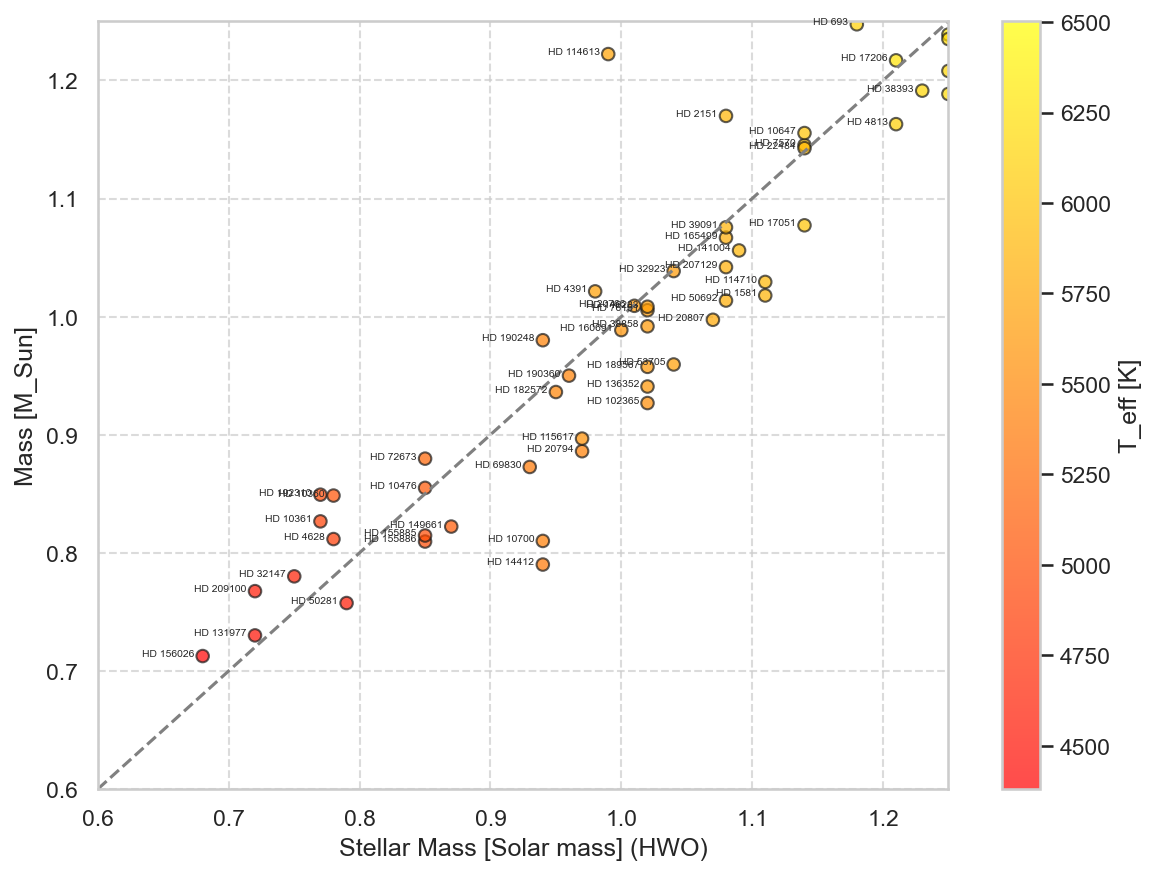

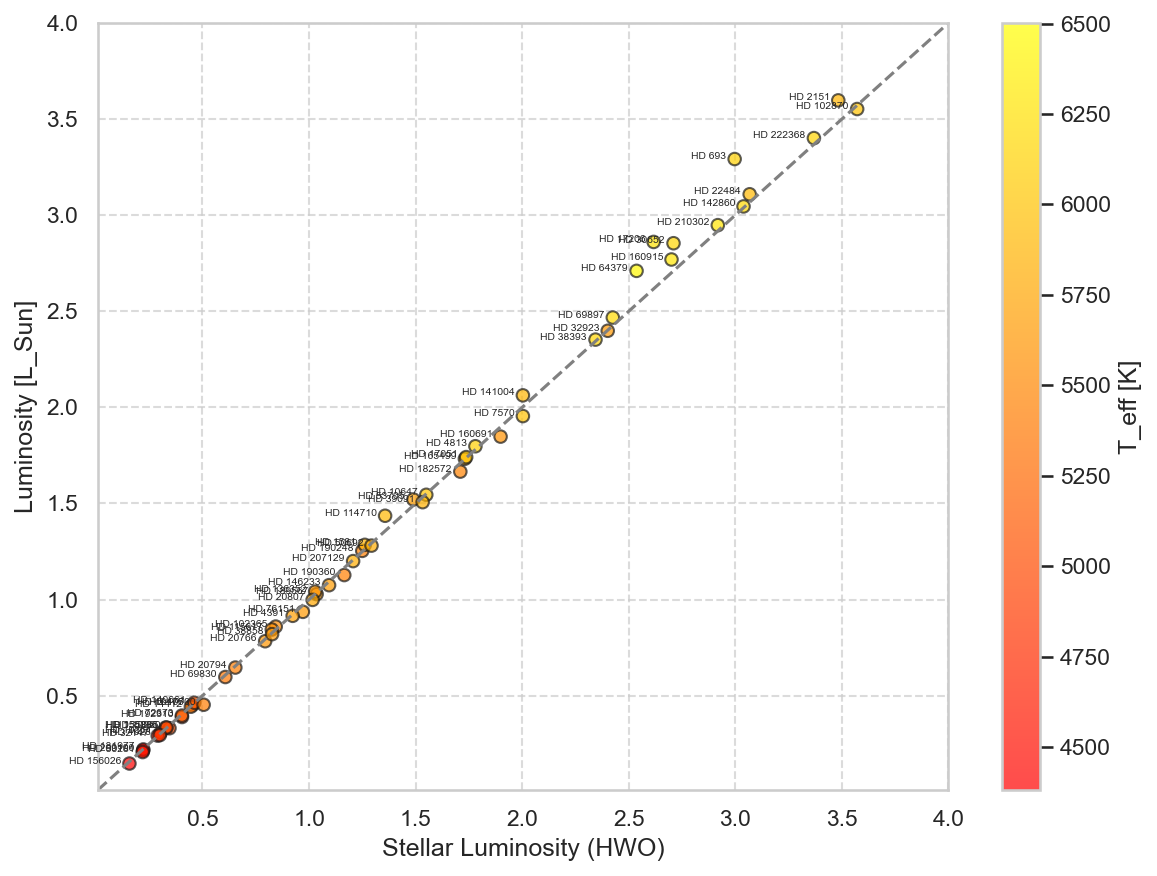

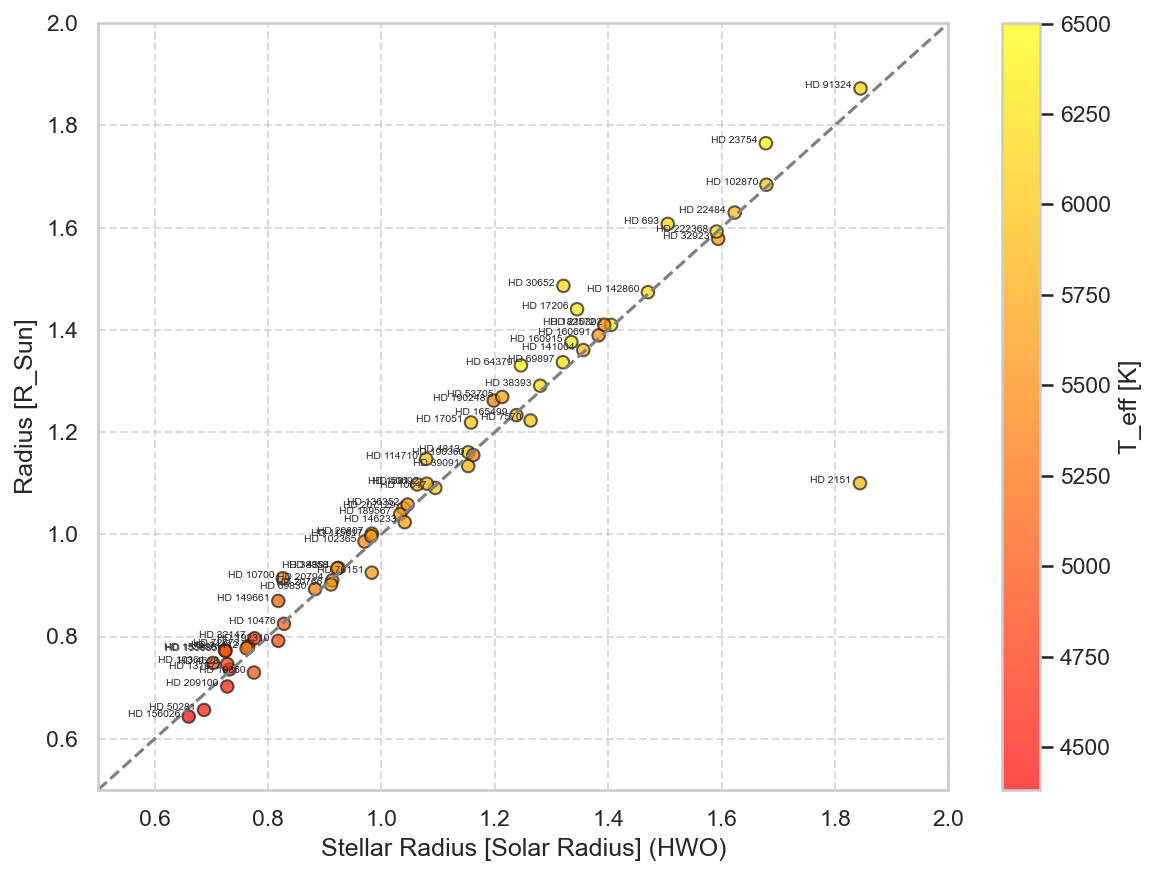

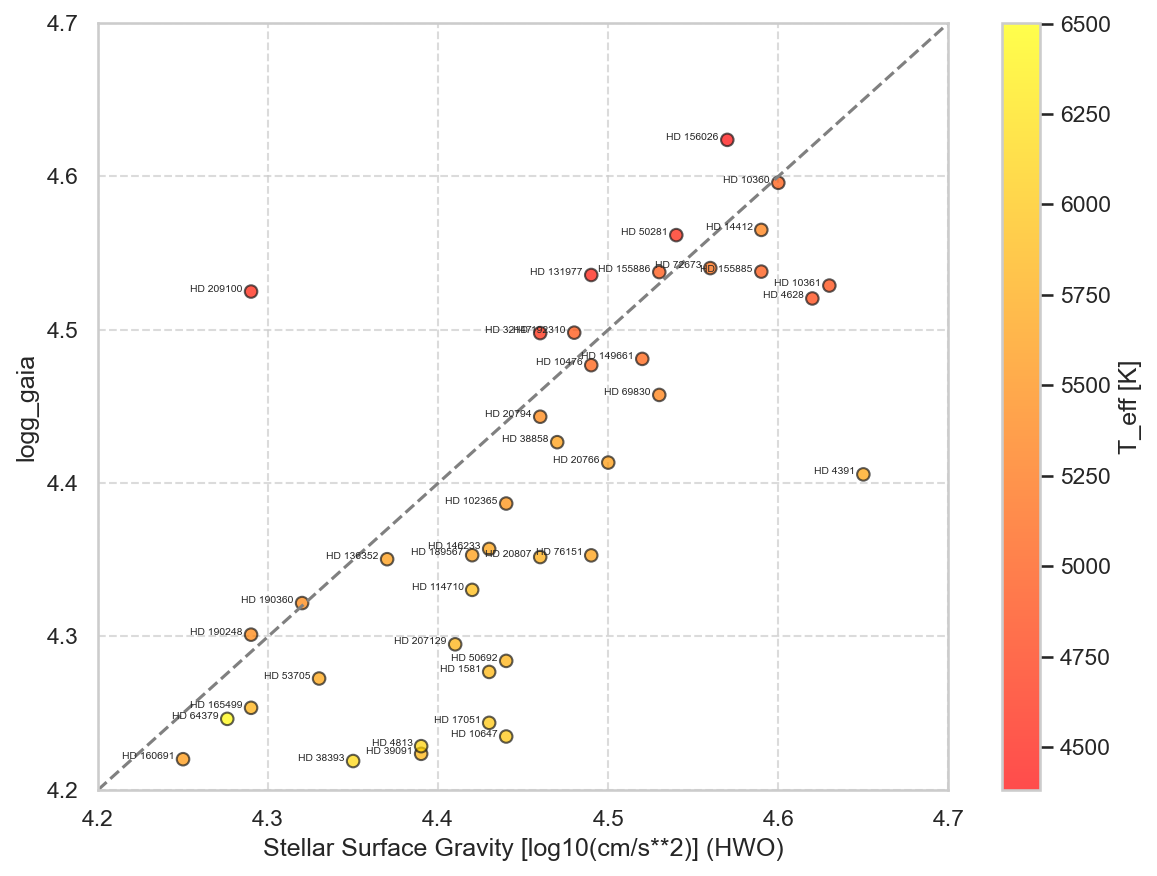

In [8]:
plot_scatter_with_options(merged_HWO, 'Stellar Effective Temperature [K] (HWO)', 'T_eff [K]', min_value = 4000, max_value = 6500, label=True)
plot_scatter_with_options(merged_HWO, 'Stellar Mass [Solar mass] (HWO)', 'Mass [M_Sun]', min_value = 0.6, max_value = 1.25, label=True)
merged_HWO['Stellar Luminosity (HWO)'] = 10**merged_HWO['Stellar Luminosity [log10(Solar)] (HWO)']
plot_scatter_with_options(merged_HWO, 'Stellar Luminosity (HWO)', 'Luminosity [L_Sun]', min_value = 0.01, max_value=4, label=True)
plot_scatter_with_options(merged_HWO, 'Stellar Radius [Solar Radius] (HWO)', 'Radius [R_Sun]', min_value = 0.5, max_value=2, label=True)
plot_scatter_with_options(merged_HWO, 'Stellar Surface Gravity [log10(cm/s**2)] (HWO)', 'logg_gaia', min_value = 4.2, max_value = 4.7, label=True)




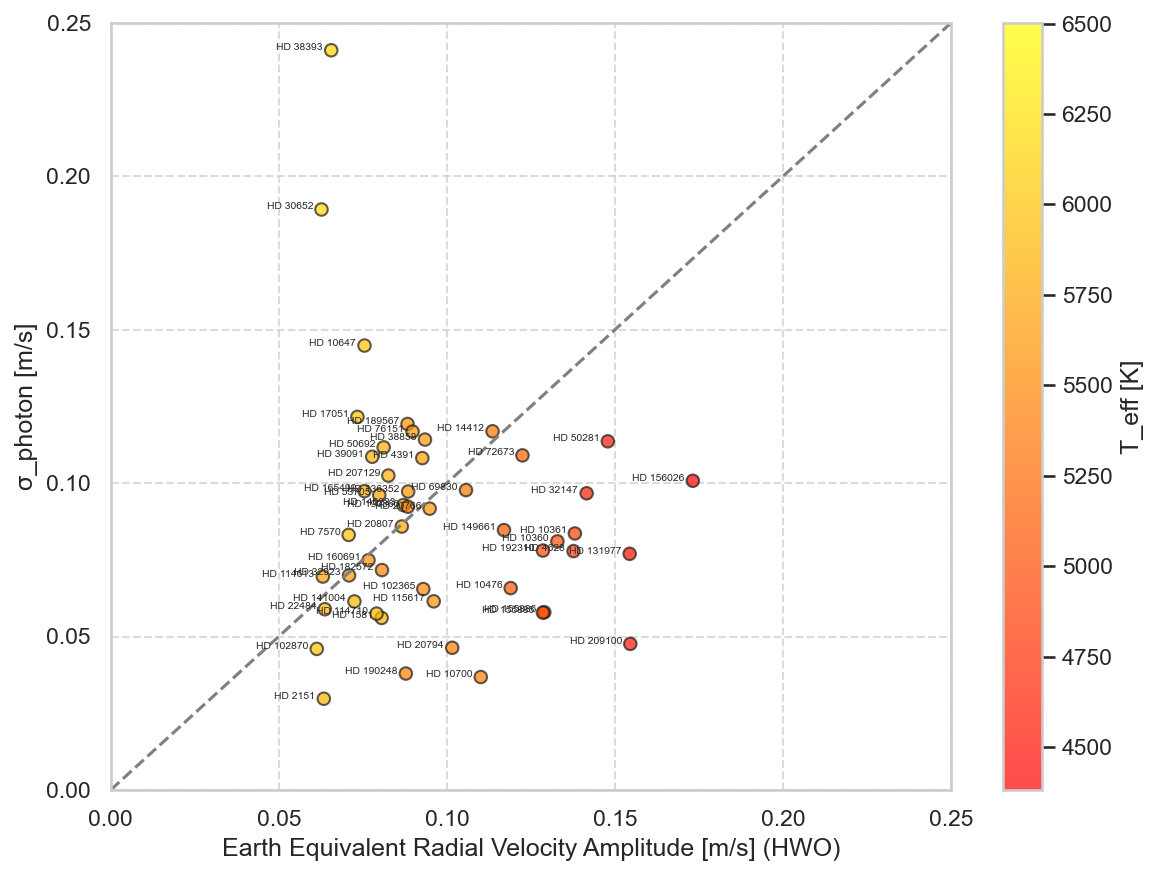

In [9]:
merged_HWO['Earth Equivalent Radial Velocity Amplitude [m/s] (HWO)'] = merged_HWO['Earth Equivalent Radial Velocity Amplitude [cm/s] (HWO)'] / 100
plot_scatter_with_options(merged_HWO, 'Earth Equivalent Radial Velocity Amplitude [m/s] (HWO)', 'σ_photon [m/s]', min_value = 0., max_value=0.25, label=True)
